In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence

/Users/joshsmith/Git/NovoNordisk_Capstone/.env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# read original data from 
data = pd.read_csv('../../dataframes/DF_prest.csv', index_col=0)

# setup 'docs' for use with Tokenizer
def aa_seq_doc(aa_sequence):
    return ' '.join(aa_sequence)

# split quantiles
def assign_class(conc):
    if conc <= low_cut:
        return 0
    elif conc >= high_cut:
        return 1
    return

data['aa_seq_doc'] = data['aa_seq'].apply(aa_seq_doc)
data = data[pd.notnull(data['aa_seq_doc'])]

# identify high and low classes by conc_cf quantiles
low_cut = data['conc_cf'].quantile(0.25)
high_cut = data['conc_cf'].quantile(0.75)

data['class'] = data['conc_cf'].apply(assign_class)
data = data[pd.notnull(data['class'])]
# check shape
print('data shape: ', data.shape)

data shape:  (22605, 8)


In [4]:
# define sequence documents
docs = list(data['aa_seq_doc'])
# create the tokenizer
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(docs)

# integer encode documents
X = t.texts_to_sequences(docs)
y = data['class'].values
max_seq_length = 200
X = sequence.pad_sequences(X, maxlen=max_seq_length)

# create test-train split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# fix random seed for reproducibility
np.random.seed(42)

# load the dataset but only keep the top n words, zero the rest
top_words = len(t.word_index) + 1

# Hook LSTM to basic CNN

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Train on 15823 samples, validate on 6782 samples
Epoch 1/15
15823/15823 [==============================] - 35s 2ms/step - loss: 0.6622 - acc: 0.5987 - val_loss: 0.6462 - val_acc: 0.6233
Epoch 2/15
15823/15823 [==============================] - 34s 2ms/step - loss: 0.6323 - acc: 0.6474 - val_loss: 0.6541 - val_acc: 0.6132
Epoch 3/15
15823/15823 [==============================] - 34s 2ms/step - loss: 0.6293 - acc: 0.6484 - val_loss: 0.6279 - val_acc: 0.6556
Epoch 4/15
15823/15823 [==============================] - 35s 2ms/step - loss: 0.6193 - acc: 0.6583 - val_loss: 0.6348 - val_acc: 0.6303
Epoch 5/15
15823/15823 [==============================] - 34s 2ms/step - loss: 0.6135 - acc: 0.6638 - val_loss: 0.6138 - val_acc: 0.6601
Epoch 6/15
15823/15823 [==============================] - 36s 2ms/step - loss: 0.5943 - acc: 0.6838 - val_loss: 0.5952 - val_acc: 0.6840
Epoch 7/15
15823/15823 [======================

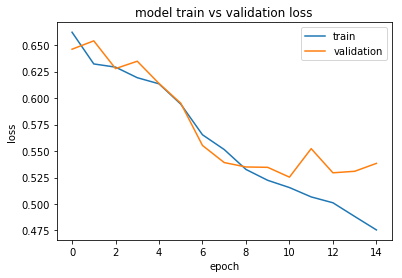

In [5]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
from keras.layers.embeddings import Embedding

# create the model
embedding_vecor_length = 16
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_seq_length))
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='selu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# record training progress
history = model.fit(X_train, y_train, epochs=15, batch_size=64,
                    validation_data=(X_test, y_test))

# plot loss vs. epoch
# https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# reduce embedding dimensionality with tSNE for visualization

In [6]:
# do PCA and/or t-SNE with embedding weights
# dictionaries here to add amino acid type/polarity 
# to color markers in the tSNE plots
codon_to_aa = {
    'aaa': 'k', 'aat': 'n', 'aac': 'n', 'aag': 'k',
    'ata': 'i', 'att': 'i', 'atc': 'i', 'atg': 'm', 
    'aca': 't', 'act': 't', 'acc': 't', 'acg': 't', 
    'aga': 'r', 'agt': 's', 'agc': 's', 'agg': 'r', 
    'taa': 'stop', 'tat': 'y', 'tac': 'y', 'tag': 'stop', 
    'tta': 'l', 'ttt': 'f', 'ttc': 'f', 'ttg': 'l', 
    'tca': 's', 'tct': 's', 'tcc': 's', 'tcg': 's', 
    'tga': 'stop', 'tgt': 'c', 'tgc': 'c', 'tgg': 'w', 
    'caa': 'q', 'cat': 'h', 'cac': 'h', 'cag': 'q', 
    'cta': 'l', 'ctt': 'l', 'ctc': 'l', 'ctg': 'l', 
    'cca': 'p', 'cct': 'p', 'ccc': 'p', 'ccg': 'p', 
    'cga': 'r', 'cgt': 'r', 'cgc': 'r', 'cgg': 'r', 
    'gaa': 'e', 'gat': 'd', 'gac': 'd', 'gag': 'e', 
    'gta': 'v', 'gtt': 'v', 'gtc': 'v', 'gtg': 'v', 
    'gca': 'a', 'gct': 'a', 'gcc': 'a', 'gcg': 'a', 
    'gga': 'g', 'ggt': 'g', 'ggc': 'g', 'ggg': 'g',
    'zero': 'zero'
}

aa_properties = {
    'i': {'hydropathy': 4.5, 'type': 0, 'code': 0},
    'v': {'hydropathy': 4.2, 'type': 0, 'code': 1},
    'l': {'hydropathy': 3.8, 'type': 0, 'code': 2},
    'f': {'hydropathy': 2.8, 'type': 1, 'code': 3},
    'c': {'hydropathy': 2.5, 'type': 0, 'code': 4},
    'm': {'hydropathy': 1.9, 'type': 0, 'code': 5},
    'a': {'hydropathy': 1.8, 'type': 0, 'code': 6},
    'g': {'hydropathy': -0.4, 'type': 2, 'code': 7},
    't': {'hydropathy': -0.7, 'type': 2, 'code': 8},
    's': {'hydropathy': -0.8, 'type': 2, 'code': 9},
    'w': {'hydropathy': -0.9, 'type': 1, 'code': 10},
    'y': {'hydropathy': -1.3, 'type': 1, 'code': 11},
    'p': {'hydropathy': -1.6, 'type': 2, 'code': 12},
    'h': {'hydropathy': -3.2, 'type': 2, 'code': 13},
    'e': {'hydropathy': -3.5, 'type': 3, 'code': 14},
    'q': {'hydropathy': -3.5, 'type': 2, 'code': 15},
    'd': {'hydropathy': -3.5, 'type': 3, 'code': 16},
    'n': {'hydropathy': -3.5, 'type': 2, 'code': 17},
    'k': {'hydropathy': -3.9, 'type': 4, 'code': 18},
    'r': {'hydropathy': -4.5, 'type': 4, 'code': 19},
    'stop': {'hydropathy': 5, 'type': 5, 'code': 20},
    'zero': {'hydropathy': 5, 'type': 6, 'code': 21},
}

In [7]:
embedding_weights = model.layers[0].get_weights()[0]
t.word_index['zero'] = 0  # account for zero being added

In [17]:
from sklearn.manifold import TSNE
from scipy.spatial import distance_matrix
import seaborn as sns

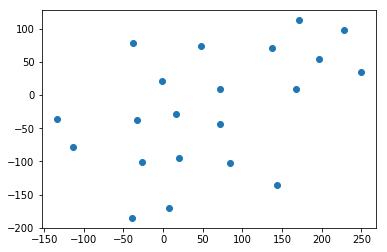

In [18]:
X_embedded = TSNE(n_components=2, n_iter=5000, n_iter_without_progress=5000,
                  perplexity=10).fit_transform(embedding_weights)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])

In [19]:
df = pd.DataFrame(X_embedded)
for key, value in t.word_index.items():
    df.loc[value, 'aa'] = key
    df.loc[value, 'hydropathy'] = aa_properties[key]['hydropathy']
    df.loc[value, 'type'] = aa_properties[key]['type']
    df.loc[value, 'code'] = aa_properties[key]['code']
df

,0,1,aa,hydropathy,type,code
0,71.908417,-43.166515,zero,5.0,6.0,21.0
1,171.846222,112.537270,l,3.8,0.0,2.0
2,16.002319,-27.851439,s,-0.8,2.0,9.0
3,-113.733307,-77.527283,e,-3.5,3.0,14.0
4,71.658318,8.838832,a,1.8,0.0,6.0
5,84.429634,-102.160698,g,-0.4,2.0,7.0
6,143.372086,-135.336105,p,-1.6,2.0,12.0
7,167.047729,9.351439,v,4.2,0.0,1.0
8,-39.015667,-184.901077,k,-3.9,4.0,18.0
9,6.953431,-170.711563,r,-4.5,4.0,19.0


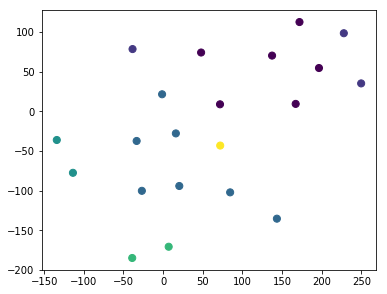

In [20]:
plt.figure(figsize=(6,6))
plt.scatter(df.loc[:, 0], df.loc[:, 1], c=df.loc[:,'type'], s=50,)
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

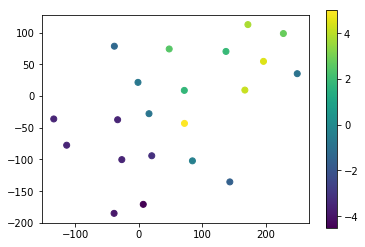

In [21]:
plt.scatter(df.loc[:, 0], df.loc[:, 1], c=df.loc[:,'hydropathy'])
plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()
plt.savefig('aa_tsne_hydropathy.png', dpi=300)

In [22]:
import plotly.plotly as py
import plotly.graph_objs as go

trace0 = go.Scatter(
    x = df.loc[:, 0],
    y = df.loc[:, 1],
    name = 'aa',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = 'rgba(152, 0, 0, .8)',
        line = dict(
            width = 2,
            color = 'rgb(0, 0, 0)'
        )
    ),
    text=df['aa']
)

data = [trace0]

layout = dict(title = 'aa embedding',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False)
             )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')

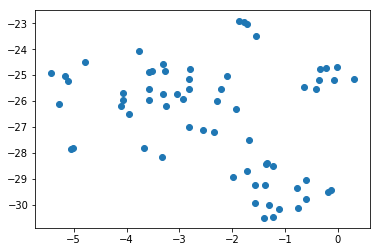

In [48]:
X_embedded = TSNE(n_components=2, n_iter=5000, n_iter_without_progress=5000,
                  perplexity=30).fit_transform(embedding_weights)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])

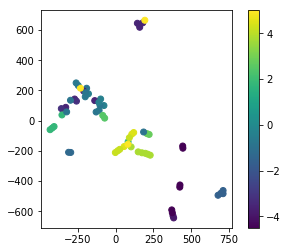

In [22]:
X_embedded = TSNE(n_components=2, n_iter=5000, n_iter_without_progress=5000,
                  perplexity=2).fit_transform(embedding_weights)
df = pd.DataFrame(X_embedded)
for key, value in t.word_index.items():
    df.loc[value, 'codon'] = key
    df.loc[value, 'aa'] = codon_to_aa[key]
    df.loc[value, 'hydropathy'] = aa_properties[codon_to_aa[key]]['hydropathy']
    df.loc[value, 'type'] = aa_properties[codon_to_aa[key]]['type']
    df.loc[value, 'code'] = aa_properties[codon_to_aa[key]]['code']
    
plt.scatter(df.loc[:, 0], df.loc[:, 1], c=df.loc[:,'hydropathy'])
plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()
#plt.savefig('hydropathy.png', dpi=300)    

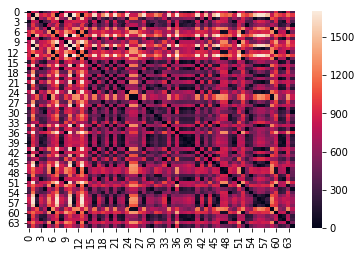

In [73]:
tSNE_dist = distance_matrix(X_embedded, X_embedded)
sns.heatmap(tSNE_dist)

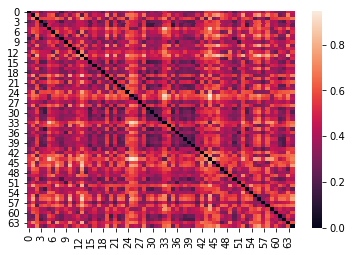

In [60]:
embedding_dist = distance_matrix(embedding_weights, embedding_weights)
sns.heatmap(embedding_dist)

# test PCA to appease wondering minds

In [12]:
from sklearn.decomposition import PCA
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
pca = PCA(n_components=2)
X_embedded = pca.fit_transform(embedding_weights)

In [13]:
print(pca.explained_variance_ratio_)  
print(pca.singular_values_)  

[0.33582538 0.19307823]
[1.5915599 1.2067933]


In [14]:
df = pd.DataFrame(X_embedded)
for key, value in t.word_index.items():
    df.loc[value, 'codon'] = key
    df.loc[value, 'aa'] = codon_to_aa[key]
    df.loc[value, 'hydropathy'] = aa_properties[codon_to_aa[key]]['hydropathy']
    df.loc[value, 'type'] = aa_properties[codon_to_aa[key]]['type']
    df.loc[value, 'code'] = aa_properties[codon_to_aa[key]]['code']
df

,0,1,codon,aa,hydropathy,type,code
0,0.058000,-0.000567,zero,zero,5.0,6.0,21.0
1,0.256586,0.157487,gag,e,-3.5,3.0,14.0
2,-0.357639,-0.026564,ctg,l,3.8,0.0,2.0
3,0.130140,0.035185,cag,q,-3.5,2.0,15.0
4,0.134844,-0.061936,ggc,g,-0.4,2.0,7.0
5,0.069956,-0.317533,ccc,p,-1.6,2.0,12.0
6,0.033905,-0.242956,aag,k,-3.9,4.0,18.0
7,0.268037,0.161337,gaa,e,-3.5,3.0,14.0
8,0.130483,0.021735,cac,h,-3.2,2.0,13.0
9,-0.130328,0.102735,gtg,v,4.2,0.0,1.0


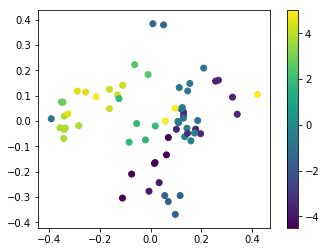

In [15]:
plt.scatter(df.loc[:, 0], df.loc[:, 1], c=df.loc[:,'hydropathy'])
plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()
# plt.savefig('pca_hydropathy.png', dpi=300)

In [16]:
import plotly.plotly as py
import plotly.graph_objs as go

trace0 = go.Scatter(
    x = df.loc[:, 0],
    y = df.loc[:, 1],
    name = 'codons',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = 'rgba(152, 0, 0, .8)',
        line = dict(
            width = 2,
            color = 'rgb(0, 0, 0)'
        )
    ),
    text=df['aa']
)

data = [trace0]

layout = dict(title = 'codon embedding',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False)
             )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')

PCA doesn't separate like amino acids as clearly as tSNE